<h1>Direct Stiffness Method: Planar Truss</h1>
<h3>ME309: Structural Mechanics, Boston University</h3>
<h4>Prof. Douglas P. Holmes</h4>

<img src = "https://upload.wikimedia.org/wikipedia/commons/3/37/Bu-bridge.jpg" />
<a href="https://en.wikipedia.org/wiki/Boston_University_Bridge">BU Bridge</a>, <i>steel truss through arch bridge</i>

The basic idea behind the <b>finite element method</b> (FEM) is that a real structure can be divided up, or <i>discretized</i> into a finite number of elements that are connected at nodes, and perhaps also along the boundaries between nodes. The simplest type of element is a <i>bar element</i>. A bar is an element that can only withstand axial loading - stretching or compression. For a planar truss, each bar element will have two nodes - the points at which each element is connected to another element or a support. A bar element is modeled as a linear spring with an effective spring stiffness of $k=EA/L$, where $E$ is Young's elastic modulus, and $A$ is the cross-sectional area. These bar elements can be connected by pins that do not resist rotation at each node to form a <i>truss</i>. Our goal is to solve the force-displacement relations for the entire truss, <i>i.e.</i> $\mathbf{F}=\mathbf{K}\mathbf{u}$. 

We will solve this problem using the <b>direct stiffness method</b>, whereby we:
<ol>
    <li><b>Idealize</b> the structure.</li>
    <li><b>Breakdown</b> the truss into separate, disconnected elements.</li>
    <li><b>Assemble</b> the elements back into a truss, apply the boundary and force conditions, and solve</li>
</ol>

Here is an overview of idealizing and breaking down the structure:

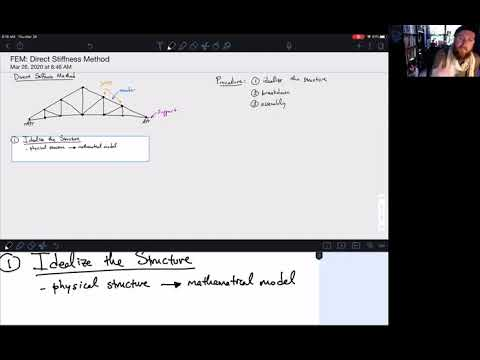

In [9]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('ZNP9W558BMs',width=1280,height=720)

Our procedure for solving this problem will proceed as follows:
<ol>
    <li>Define the geometry and materials of the truss. Where are the nodes, what elements are connected by these nodes, and what are $E$ and $A$ for each element? </li>
    <li>What are the boundary conditions, e.g. constraints on displacements $\mathbf{u}$ and applied forces $\mathbf{F}$? </li>
    <li>Calculate $\mathbf{K}$.</li>
    <ol>
        <li>Calculate $\mathbf{K}_{el}$ for each element.</li>
        <li>Augment $\mathbf{K}_{el}$ to the size of $\mathbf{K}$ </li>
        <li>Add each augmented $\mathbf{K}_{el}$ to $\mathbf{K}$</li>
    </ol>
    <li>The system is underdetermined, so next we removed the known/specified displacements from $\mathbf{u}$ and solve for the displacements of the free nodes.</li>
    <li>To complete the problem, we solve for the unknown reaction forces in $\mathbf{F}$.</li>
</ol>

### Python & Jupyter Notebooks
We will implement the direct stiffness method using <i>Python</i>. The best and easiest way to get <i>Python</i> and  is through [Anaconda](https://www.anaconda.com/distribution/). If you would like to play with this code without installing <i>Python</i> and <i>Jupyter Notebooks</i> locally, then you can open this code in Google Colab (open the link below in a new tab):

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dpholmes/DirectStiffnessMethod/blob/master/planarTruss.ipynb)

<b>Importing Python Libraries</b>: In order to use mathematical functions, work with matrices, do symbolic calculations, and plot graphs, we will import a variety of python libraries:

In [1]:
# Here are some common libraries that expand the functionality of python
import math         # sine, cosine, sqrt, etc.
import numpy as np  # so we can work with matrices

import matplotlib
import matplotlib.pyplot as plt # plotting

import sympy as sp # symbolic calculations

<h2>Geometry, Materials, and Boundary Conditions</h2>
Here, we will define the ($x$,$y$) coordinates of each node.

In [2]:
# [x1,y1], ... the (x,y) position of node 1, 2, 3...
nodes = np.array([
    [0,4],
    [3,4],
    [0,0],
    [3,0],
    [6,0]
])
# a list of all the nodes, and a list of all degrees of freedome (DoF)
node_numbers = np.array([*range(len(nodes))])
node_DoF = np.array([*range(2*len(nodes))])

Next, define the elements. I chose to do this such that element $e$ is connected to the $i$th and $j$th nodes, and has Young's modulus $E$, and cross sectional area $A$. 

In [3]:
# element e is connected at nodes i and j
# element e: [node i, node j, Young's Modulus, Cross Sectional Area] ... note: we'll calculate L later
elements = np.array([
    [1, 2, 2e11, 1e-5],
    [1, 3, 2e11, 1e-5],
    [3, 2, 2e11, 1e-5],
    [2, 4, 2e11, 1e-5],
    [2, 5, 2e11, 1e-5],
    [3, 4, 2e11, 1e-5],
    [4, 5, 2e11, 1e-5]
])

Let's plot our structure in its original, undeformed, or reference, state:

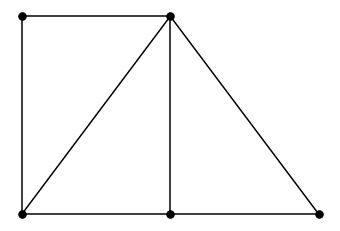

In [4]:
# set axes aspect ratio = 1
# turn off the axis
plt.axes().set_aspect('equal') 
plt.axis('off') 

# plot the nodes
plt.plot(nodes[:,0], nodes[:,1], 'k.',markersize=15)
# plot the elements
# loop through the list of elements, grab the x position and y position of each node associated with that element
# the line: 'elements[i,0]-1' is necessary because python starts counting at 0, not 1 (like MATLAB)
for i in range(len(elements)):
    plt.plot(np.array([
    nodes[int(elements[i,0]-1),0], nodes[int(elements[i,1]-1),0]]),
         np.array([nodes[int(elements[i,0]-1),1], nodes[int(elements[i,1]-1),1]]),
         'k-')
plt.show()

Now, we impose our boundary conditions. The Dirichlet conditions on displacement are typically inputted as list containing the node, the degree of freedom ($x=1$,$y=2$), and the magnitude of displacement.

In [5]:
# dirichlet boundary conditions
# [node, DoF (x=1, y=2), value]
bc = np.array([
    [1,1,0],
    [1,2,0],
    [3,1,0],
    [5,1,0],
    [5,2,0]
])

Forces are applied at node 3, we'll enter the node, degree of freedom, and magnitude.

In [6]:
# neumann boundary conditions - e.g. forces
# [node, DoF (x=1,y=2), magnitude of force]
forces = np.array([
    [2,1, 10e4],
    [4,2,-10e4]
])

<h2>Master Stiffness Matrix</h2>
First, we initialize our force and displacement vectors along with our master stiffness matrix. 

In [7]:
# initializing the vectors F, u, and the matrix K
F = u = np.zeros(2*len(nodes))
K = np.zeros([2*len(nodes), 2*len(nodes)])

It will be useful to convert the nodes into $x$, $y$ coordinates. We can use these coordinates to calculate $L$ for each element, as well as each element's angle from the horizontal plane defined by the coordinate system of the structure.

In [8]:
# given an element e, what are the (x,y) coordinates of each node?
def XY(nodes, elements, e):
    return np.array([
        nodes[int(elements[e,0]-1)],
        nodes[int(elements[e,1]-1)]
    ])

In [10]:
# for element e, what degrees of freedom in the structure do the nodes correspond to?
def elementDoF(node_DoF, elements, i):
    node_i = int(elements[i,:2][0])-1 # -1 is for python counting
    node_j = int(elements[i,:2][1])-1 # -1 is for python counting
    
    elementDoF = np.array([
        [node_DoF[2*node_i]],
        [node_DoF[2*node_i+1]],
        [node_DoF[2*node_j]],
        [node_DoF[2*node_j+1]],
    ])

    return elementDoF

### Elemental Stiffness Matrix
Here is an overview of how to derive the elemental stiffness matrix:

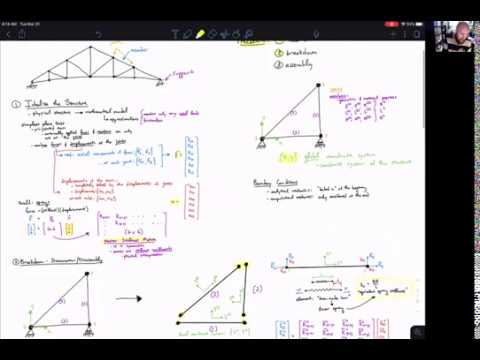

In [16]:
YouTubeVideo('_U00ovcmNbc',width=1280,height=720)

Let's define a function to calculate the elemental stiffness matrix for each element. We'll use the notation $c \equiv \cos{\theta}$ and $s \equiv \sin{\theta}$. Recall that the $\cos{\theta}=\frac{x_2-x_1}{L}$ and $\sin{\theta}=\frac{y_2-y_1}{L}$.

In [9]:
# elemental stiffness matrix in global coordinates
def Kel(XY, E, A):
    x1, y1, x2, y2 = XY[0,0], XY[0,1], XY[1,0], XY[1,1]
    
    L = math.sqrt((x2-x1)**2 + (y2-y1)**2)
    c = (x2-x1)/L
    s = (y2-y1)/L
    
    Kel = E*A/L*np.array([
        [c**2, c*s, -c**2, -c*s],
        [c*s, s**2, -c*s, -s**2],
        [-c**2, -c*s, c**2, c*s],
        [-c*s, -s**2, c*s, s**2]
    ])
    
    return Kel  

In [12]:
# augment the elemental stiffness matrix by inserting the local stiffness matrix 
# into the correct location within the global stiffness matrix.
# this could be done more efficiently, but i will add a visualization above to help identify what goes where

def Kaug(K, e, Kel, node_DoF):
    i = elementDoF(node_DoF, elements, e)[0][0]
    j = elementDoF(node_DoF, elements, e)[1][0]
    k = elementDoF(node_DoF, elements, e)[2][0]
    l = elementDoF(node_DoF, elements, e)[3][0]
    
    K[i][i] += Kel[0][0] 
    K[j][j] += Kel[1][1]
    K[i][j] += Kel[0][1]
    K[j][i] += Kel[0][1]
    
    K[k][k] += Kel[2][2]
    K[l][l] += Kel[3][3]
    K[k][l] += Kel[2][3]
    K[l][k] += Kel[2][3]    
    
    K[i][k] += Kel[0][2]
    K[k][i] += Kel[0][2]    
    K[i][l] += Kel[0][3]
    K[l][i] += Kel[0][3]    
    K[j][k] += Kel[1][2]
    K[k][j] += Kel[1][2]    
    K[j][l] += Kel[1][3]
    K[l][j] += Kel[1][3]    
    
    return K

In [13]:
def MasterStiffness(nodes, node_DoF, elements, K):
# Calculate the Master Stiffness matrix:
# 1. Get the x & y coordinates of each node connected to element i
# 2. Calculate the stiffness matrix for element i
# 3. Augment the elemental stiffness matrix to the size of K
# 4. Add it to K, loop over the remaining elements
    for i in range(len(elements)):
        nodesXY = XY(nodes, elements, i)
        Keli  = Kel(nodesXY, elements[i,2], elements[i,3])
        K = Kaug(K, i, Keli, node_DoF)    
    return K

<h3>Calculate $\mathbf{K}$</h3>

In [14]:
K = MasterStiffness(nodes, node_DoF, elements, K)

In [15]:
sp.Matrix(K)

Matrix([
[ 666666.666666667,       0.0, -666666.666666667,       0.0,               0.0,       0.0,               0.0,       0.0,               0.0,       0.0],
[              0.0,  500000.0,               0.0,       0.0,               0.0, -500000.0,               0.0,       0.0,               0.0,       0.0],
[-666666.666666667,       0.0,  954666.666666667,       0.0,         -144000.0, -192000.0,               0.0,       0.0,         -144000.0,  192000.0],
[              0.0,       0.0,               0.0, 1012000.0,         -192000.0, -256000.0,               0.0, -500000.0,          192000.0, -256000.0],
[              0.0,       0.0,         -144000.0, -192000.0,  810666.666666667,  192000.0, -666666.666666667,       0.0,               0.0,       0.0],
[              0.0, -500000.0,         -192000.0, -256000.0,          192000.0,  756000.0,               0.0,       0.0,               0.0,       0.0],
[              0.0,       0.0,               0.0,       0.0, -666666.666666667,

<h2>Solving for the displacements of the free nodes</h2>
Here is an overview of how to solve this matrix equation for the unknown displacements, and then the reaction forces at the supports.

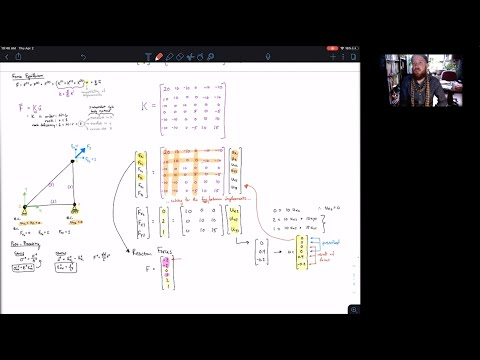

In [17]:
YouTubeVideo('LTU1mECLkHs',width=1280,height=720)

In [16]:
# initialize vectors for the specified displacements and forces. these will be [1 x DoF]
u_specified=[]
F_specified=[0]*2*len(nodes)

# what DoF are specified?
for i in range(len(bc)):
    u_specified.append(2*(bc[i,0]-1)+bc[i,1]-1)
# assign the external forces to the corresponding DoF in F   
for i in range(len(forces)):    
    F_specified[(2*(int(forces[i,0])-1)+int(forces[i,1])-1)]=forces[i,2]
    
u_unknown = np.delete(u,u_specified) # deleting the specified displacments from u
K_reduced = np.delete(K,u_specified,0) # deleting rows
K_reduced = np.delete(K_reduced,u_specified,1) # deleting columns
F_specified = np.delete(F_specified,u_specified) # deleting the forces that correspond to specified displacments

In [17]:
sp.Matrix(F_specified)

Matrix([
[ 100000.0],
[      0.0],
[      0.0],
[      0.0],
[-100000.0]])

In [18]:
sp.Matrix(K_reduced)

Matrix([
[954666.666666667,       0.0, -192000.0,              0.0,       0.0],
[             0.0, 1012000.0, -256000.0,              0.0, -500000.0],
[       -192000.0, -256000.0,  756000.0,              0.0,       0.0],
[             0.0,       0.0,       0.0, 1333333.33333333,       0.0],
[             0.0, -500000.0,       0.0,              0.0,  500000.0]])

In [19]:
# np.linalg.lstsq does the matrix left division. 
# it returns the residuals, rank, etc. of the calculation, so we just grab the list, which is element [0]
u_unknown = np.linalg.lstsq(K_reduced,F_specified, rcond=None)[0]

In [20]:
u_unknown

array([ 0.09454976, -0.22066795, -0.0507109 ,  0.        , -0.42066795])

Putting the displacments of the free/unconstrained nodes back into the displacement vector $\mathbf{u}$.

In [21]:
# create a list of all the displacement degrees of freedom (DoF)
u_DoF=[]
for i in range(len(u)):
    u_DoF.append(i)

# get the index locations of the free degrees of freedom (DoF)    
u_free = (list(set(u_DoF) - set(u_specified)))    

# put the free (formerly unknown) displacements into the displacement vector u
np.put(u,u_free,u_unknown)

In [22]:
sp.Matrix(u)

Matrix([
[                0.0],
[                0.0],
[ 0.0945497630331754],
[ -0.220667950236967],
[                0.0],
[-0.0507109004739336],
[                0.0],
[ -0.420667950236967],
[                0.0],
[                0.0]])

Solving for the unknown reaction forces.

In [23]:
F=np.dot(K,u)

In [24]:
sp.Matrix(F)

Matrix([
[   -63033.1753554503],
[    25355.4502369668],
[            100000.0],
[-1.4915713109076e-10],
[    19016.5876777252],
[9.45874489843845e-11],
[                 0.0],
[           -100000.0],
[   -55983.4123222749],
[    74644.5497630333]])

<h2>Plotting the initial and deformed truss</h2>
First, let's collect the new location of the nodes.

In [25]:
nodes_new = nodes+np.reshape(u,(len(nodes),2))

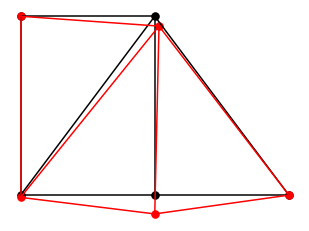

In [26]:
# set axes aspect ratio = 1
# turn off the axis
plt.axes().set_aspect('equal') 
plt.axis('off') 

# plot the nodes
plt.plot(nodes[:,0], nodes[:,1], 'k.',markersize=15)
plt.plot(nodes_new[:,0], nodes_new[:,1], 'r.',markersize=15)
# plot the elements
# loop through the list of elements, grab the x position and y position of each node associated with that element
# the line: 'elements[i,0]-1' is necessary because python starts counting at 0, not 1 (like MATLAB)
for i in range(len(elements)):
    plt.plot(np.array([
    nodes[int(elements[i,0]-1),0], nodes[int(elements[i,1]-1),0]]),
         np.array([nodes[int(elements[i,0]-1),1], nodes[int(elements[i,1]-1),1]]),
         'k-')
# plot the deformed elements
for i in range(len(elements)):
    plt.plot(np.array([
    nodes_new[int(elements[i,0]-1),0], nodes_new[int(elements[i,1]-1),0]]),
         np.array([nodes_new[int(elements[i,0]-1),1], nodes_new[int(elements[i,1]-1),1]]),
         'r-')    
plt.show()